# Text classification

- Assign input text into categories (classes):
  - Filtering (e.g. spam / non-spam)
  - Topic identification (e.g. politics, sports, business)
  - Sentiment analysis (positive / negative / neutral)
  - Language identification (Finnish, English, ...)
  - Authorship attribution (who wrote this text?)
  - (and many more)
  
---  

**Example**: classify each of the following email subject lines as `spam` or `ham` (non-spam)

```
  Subject: want to make more money ?
  Subject: during / after hours contact information
  Subject: learn to save on medications at discount pharmacy
  Subject: invitation to dinner
  Subject: your 60 second auto loan will be accepted
  Subject: diet medications online
  Subject: december preliminary production estimate
  Subject: first deliveries - comstock oil & gas and united oil & mineral
```

# Learning to classify text
  
- In this lesson, focus on **supervised** classification
  - We assume a *training set* of example inputs (texts) with correct outputs (classes)
  - (Unsupervised classification (clustering) covered separately)
- Machine learning approach:
  - Given example texts and their classes $\textbf{y} = \{ y_1, y_2, \ldots y_n \}$
  - Represent each document as a feature vector $\textbf{x} = \{ x_1, x_2, \ldots x_n \}$  
  - Learn a function $f(X) \rightarrow Y$ to predict the class given text features
- Note: data is unordered, and there are no dependencies between texts (cf. sequence tagging)

### Overview

- Tokenization: split text into words (and non-word elements such as punctuation)
- Feature extraction: create discrete features representing the text
- Vectorization: map feature representation (human-readable) to vector form (machine-readable)
- Training: given vectorized training data and classes, train machine learning model
- Prediction: given vectorized text (or dev) data, predict classes
- Evaluation: compare predicted to true classes

# Spam classification

We'll use a version of the [Enron-Spam](http://www2.aueb.gr/users/ion/data/enron-spam/) corpus created by [Metsis et al. (2006)](http://nlp.cs.aueb.gr/pubs/ceas2006_paper.pdf) based on the [Enron email dataset](https://www.cs.cmu.edu/~./enron/) as an example text classification task.

First, let's have a look at the data.

In [1]:
import pandas as pd


def class_counts(df, label='class'):
    return df[label].value_counts().to_string(header=None)


text_data = pd.read_csv('data/enron-spam/enron-spam-subjects.tsv', sep='\t', names=('class', 'id', 'text'))
text_data = text_data[['class', 'text']]    # drop IDs

print(class_counts(text_data))

spam    16798
ham     16545


In [2]:
text_data[:5]

,class,text
0,spam,"what up , , your cam babe"
1,spam,want to make more money ?
2,spam,food for thoughts
3,spam,"miningnews . net newsletter - tuesday , januar..."
4,spam,your pharmacy ta


In [3]:
text_data[-5:]

,class,text
33338,ham,bullets 9 / 1
33339,ham,eog material
33340,ham,associate / analyst fall recruiting
33341,ham,tw bullets 1 / 26
33342,ham,dashboard enhancements


(Note that we're working with raw text: there are no lemmas, part-of-speech tags or similar.)

Split randomly into training, development and test sets. We'll again work on the training and development sets.

In [4]:
from sklearn.model_selection import train_test_split


train_texts, devel_and_test_texts = train_test_split(text_data, test_size=0.4, random_state=1234)
devel_texts, test_texts = train_test_split(devel_and_test_texts, test_size=0.5, random_state=5678)

for label, dataset in (('Training', train_texts),
                       ('Development', devel_texts),
                       ('Test', test_texts)):
    print('- {} -'.format(label))
    print(class_counts(dataset))
    print()

- Training -
spam    10071
ham      9934

- Development -
spam    3360
ham     3309

- Test -
spam    3367
ham     3302



## Feature representation

Machine learning methods do not understand text, so we need to represent it as features, using e.g.:

* Word forms, lemmas, parts-of-speech, and their combinations
* Word or character N-grams (pairs, triples, etc. of consecutive words/characters)
* Document metadata (author, time of creation, ...)
* ...

Simple document representation:

* Split text into words, create a feature for each (unique) word
* Note that this discards word order → no distinction between e.g. "man bites dog" and "dog bites man"
* *Bag-of-words* representations such as this often also encode the number of occurrences of each word
* This can be surprisingly effective: many things about texts can be learned even if you only know which words occur

In [5]:
from collections import Counter

from pprint import pprint as pretty_print


def word_features(text):
    features = {}
    for word in text.split():
        features[word] = True
    return features


def classes_and_features(dataset, featurizer=word_features):
    classes, feats = [], []
    for class_, text in dataset.values:
        classes.append(class_)
        feats.append(featurizer(text))
    return classes, feats


train_classes, train_data = classes_and_features(train_texts)
devel_classes, devel_data = classes_and_features(devel_texts)
test_classes, test_data = classes_and_features(test_texts)

pretty_print(list(train_texts.values[0]))
print()
pretty_print((train_classes[0], train_data[0]))

['spam', 'fw : upto 50 % off on prescrlpt 1 on drogs zgpxruoeyyimjhq e']

('spam',
 {'%': True,
  '1': True,
  '50': True,
  ':': True,
  'drogs': True,
  'e': True,
  'fw': True,
  'off': True,
  'on': True,
  'prescrlpt': True,
  'upto': True,
  'zgpxruoeyyimjhq': True})


## Reminder: Naive Bayes

* Simple probabilistic classifier based on class priors (`P(spam)`) and conditional feature probabilities (`P(viagra|spam)`)
* Estimate probabilities based on counts of classes and (feature, class) pairs in training data
    * Prior: `P(spam) = count(spam) / count(*)`
    * Conditional: `P(viagra|spam) = count(viagra, spam) / count(*, spam)`

In [6]:
from nltk import NaiveBayesClassifier


nb_classifier = NaiveBayesClassifier.train(zip(train_data, train_classes))

nb_classifier.show_most_informative_features(25)

Most Informative Features
                    2001 = True              ham : spam   =    143.8 : 1.0
                   meter = True              ham : spam   =    135.5 : 1.0
               interview = True              ham : spam   =     75.4 : 1.0
                 quality = True             spam : ham    =     70.0 : 1.0
                   group = True              ham : spam   =     63.2 : 1.0
                 revised = True              ham : spam   =     61.8 : 1.0
                       > = True             spam : ham    =     59.4 : 1.0
                       % = True             spam : ham    =     57.8 : 1.0
            presentation = True              ham : spam   =     57.1 : 1.0
                    2000 = True              ham : spam   =     56.4 : 1.0
              california = True              ham : spam   =     54.9 : 1.0
              nomination = True              ham : spam   =     54.9 : 1.0
                      em = True             spam : ham    =     54.9 : 1.0

In [7]:
from nltk import classify
from nltk.metrics import scores

pred_classes = nb_classifier.classify_many(devel_data)

print('{:.2%}'.format(scores.accuracy(devel_classes, pred_classes)))

93.04%


Looks OK, but accuracy is not very informative. Here we care very much about high recall, i.e. losing as few good (ham) emails as possible.

# Reminder: metrics

In the context of binary classification where one class is positive (e.g. `ham`) and the other negative (e.g. `spam`):

* Accuracy: fraction of predicted that are correct, i.e. identical to the true class
* Precision: fraction of predicted positives that are correct
* Recall: fraction of positives that were correctly predicted
* F-score: harmonic mean of precision and recall

More precisely

* True positives (**tp**): prediction **true** (i.e. correct), predicted class **positive**
* False negative (**fn**): prediction **false** (i.e. incorrect), predicted class **negative**
* True negative (**tn**): prediction **true**, predicted class **negative**
* False positive (**fp**): prediction **false**, predicted class **positive**

and

* Accuracy: (tp + tn)/(tp + fp + fn + tn)
* Precision (p): tp / (tp + fp)
* Recall (r): tp / (tp + fn)
* F-score: 2 * p * r / (p + r)

(Specifically, that's $F_1$-score, the balanced harmonic mean.)

Or, in code:

In [8]:
def counts(true_classes, pred_classes, positive_class='ham'):
    tp, fp, fn, tn = 0, 0, 0, 0
    for true, pred in zip(true_classes, pred_classes):
        if pred == true:
            if pred == positive_class:
                tp += 1
            else:
                tn += 1
        else:    # pred != true
            if pred == positive_class:
                fp += 1
            else:
                fn += 1
    return tp, fp, fn, tn


def accuracy(true_classes, pred_classes):
    tp, fp, fn, tn = counts(true_classes, pred_classes)
    return (tp + tn) / (tp + fp + fn + tn)


def precision(true_classes, pred_classes, positive_class='ham'):
    tp, fp, fn, _ = counts(true_classes, pred_classes, positive_class)
    return tp / (tp + fp)


def recall(true_classes, pred_classes, positive_class='ham'):
    tp, fp, fn, _ = counts(true_classes, pred_classes, positive_class)
    return tp / (tp + fn)


def f1_score(true_classes, pred_classes, positive_class='ham'):
    p = precision(true_classes, pred_classes, positive_class)
    r = recall(true_classes, pred_classes, positive_class)
    return 2 * p * r / (p + r)


print('Accuracy :\t{:.2%}'.format(accuracy(devel_classes, pred_classes)))
print('Precision:\t{:.2%}'.format(precision(devel_classes, pred_classes)))
print('Recall   :\t{:.2%}'.format(recall(devel_classes, pred_classes)))
print('F-score  :\t{:.2%}'.format(f1_score(devel_classes, pred_classes)))

Accuracy :	93.04%
Precision:	94.49%
Recall   :	91.30%
F-score  :	92.87%


## Why not just accuracy?

Precision, recall and F-score are used in particular when positives are only a small fraction of the data. Consider e.g. an information retrieval setting where

* The total number of documents is 1000
* There are 10 documents about apples (the fruit)
* There are 20 documents about Apple (the company)
* Looking for information about fruit, a user queries two systems for "apple":
  - **System 1** returns nothing (it never does)
  - **System 2** returns the 10 fruit documents (positive) and the 20 Apple, Inc. documents (negative)
  
Evaluation:

* **System 1** accuracy: 990 / 1000 = 0.99
* **System 2** accuracy: 980 / 1000 = 0.98

But

* **System 1** precision, recall and F-score are zero
* **System 2** precision: 10 / 30 = 0.33
* **System 2** recall: 10 / 10 = 1.0
* **System 2** F-score: 0.5

The system that returns nothing has higher accuracy, but is performs lower in terms of precision, recall, and F-score.

---

# Support Vector Machines

* Machine learning method that finds (hyper)plane that optimally separates data
* Original formulation as linear classifier in 1963, non-linear extension in 1992
* Reasonably fast and highly competitive in many tasks, including text classification
* Simple case: separate points in 2D (can't visualize >10,000D) by finding plane with *maximum margin* to nearest points

<img src="https://upload.wikimedia.org/wikipedia/commons/2/20/Svm_separating_hyperplanes.png" width="35%">

<div style="text-align:center; color:gray; font-size:80%">(Figure from <a href="https://commons.wikimedia.org/wiki/File:Svm_separating_hyperplanes.png">Wikimedia Commons</a>)</div>

* The method learns a weight vector **w** defining the orientation of the plane and a bias term $b$ defining its position

<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png" width="35%">

<div style="text-align:center; color:gray; font-size:80%">(Figure from <a href="https://commons.wikimedia.org/wiki/File:Svm_separating_hyperplanes.png">Wikimedia Commons</a>)</div>

* Convex optimization problem (unique minimum) with efficient optimization methods (esp. linear time for linear SVM)
* The solution is determined by the points "supporting" the margin (hence the name)


In general, data may not be linearly separable, and a "hard" margin may not be optimal when if it is

* To address this, the soft-margin SVM formulation allows for some, i.e. points that are inside the margin
* Tradeoff between maximizing the margin and minimizing errors controlled by cost parameter C
    * (as $C \rightarrow \infty$, the solution apporaches a hard margin)

# SVM in practice

## Feature vectorization

* SVM implementations use integer indices (0, 1, 2, ...) to identify features
    * (The same goes for other methods we have used, but the ML libraries provided a transparent string mapping)
* Before training, we explicitly map our feature sets to vectors ("vectorize" the features)

In [9]:
import sklearn.svm
from sklearn.feature_extraction.text import CountVectorizer


def basic_tokenizer(txt):
    """Simple whitespace tokenizer"""
    return txt.split()


# Map texts to sparse matrix of token counts (bag-of-words)
# Here, vectorizer.fit() learns the vocabulary, and
# vectorizer.transform() performs the mapping.
# (There is also a combined fit_transform() function.)
vectorizer = CountVectorizer(tokenizer=basic_tokenizer)
vectorizer.fit(train_texts['text'])
train_X = vectorizer.transform(train_texts['text'])

feature_names = vectorizer.get_feature_names()

print('Examples from feature index ↔ name mapping:\n')
feature_num = train_X.shape[1]
for index in range(0, feature_num, int(feature_num/25)):
    print('{:6d} ↔ {}'.format(index, feature_names[index]))

Examples from feature index ↔ name mapping:

     0 ↔ !
   544 ↔ 53813
  1088 ↔ admin
  1632 ↔ arterial
  2176 ↔ blonde
  2720 ↔ ce
  3264 ↔ condescend
  3808 ↔ decertify
  4352 ↔ dummies
  4896 ↔ eveis
  5440 ↔ friedman
  5984 ↔ harvested
  6528 ↔ india
  7072 ↔ klno
  7616 ↔ luther
  8160 ↔ model
  8704 ↔ obligations
  9248 ↔ peer
  9792 ↔ print
 10336 ↔ regressions
 10880 ↔ scarify
 11424 ↔ solutions
 11968 ↔ tailgate
 12512 ↔ turned
 13056 ↔ ward
 13600 ↔ zpalx


In [10]:
print("texts x features: {}".format(train_X.shape))

train_X

texts x features: (20005, 13616)


<20005x13616 sparse matrix of type '<class 'numpy.int64'>'
	with 132462 stored elements in Compressed Sparse Row format>

* Each text has now been mapped to a long vector (rows of the matrix)
    * the dimensions correspond to words and the values to their counts in the text
* Note that almost all of the values will be zero: no text contains more than a small fraction of possible words

<img src="figs/bow_vector.png" width="60%">

<div style="text-align:center; font-size:80%">A vector representation of the sentence "a vector representation of a sentence"</div>

In [11]:
print('Feature indices and values for an examples sentence:\n')

for index in train_X[0].nonzero()[1]:
    print('{:6d}'.format(index), feature_names[index])

Feature indices and values for an examples sentence:

     4 %
    83 1
   509 50
   920 :
  4313 drogs
  4391 e
  5517 fw
  8742 off
  8813 on
  9747 prescrlpt
 12693 upto
 13575 zgpxruoeyyimjhq


In [12]:
from sklearn.svm import LinearSVC


svm_classifier = LinearSVC(max_iter=10000)
svm_classifier.fit(train_X, train_classes)    # note that classes are strings

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [13]:
devel_X = vectorizer.transform(devel_texts['text'])

pred_classes = svm_classifier.predict(devel_X)

# svm_classifier.score(devel_X, devel_classes)

print('Accuracy : {:.2%}'.format(accuracy(devel_classes, pred_classes)))
print('Precision: {:.2%}'.format(precision(devel_classes, pred_classes)))
print('Recall   : {:.2%}'.format(recall(devel_classes, pred_classes)))
print('F-score  : {:.2%}'.format(f1_score(devel_classes, pred_classes)))

Accuracy : 92.89%
Precision: 92.97%
Recall   : 92.69%
F-score  : 92.83%


Huh, no better than Naive Bayes. Let's peek inside

In [14]:
import eli5


eli5.show_weights(svm_classifier, vec=vectorizer, top=50)

Weight?,Feature
+1.659,learn
+1.655,rolex
+1.553,money
+1.441,girls
+1.439,invite
+1.437,rotor
+1.433,404
+1.429,doctor
+1.426,1776
+1.417,impaired


(Note that only one class is shown as the task is binary: positive features for one class are negative for the other.)

---

# Recap: vector representation of text

(Expanding on yesterday's explanation)

Assume the following is our entire (training) dataset:

In [15]:
texts = [
    "money money money",
    "invitation to dinner",
    "buy medications online",
    "production estimate online",
]

Let's have a look at mapping these texts into bag-of-words vectors.

Before we do, recall that if we mapped each texts into bag-of-words features, it would look something like this:

In [16]:
from collections import Counter


featurized = []
for text in texts:
    features = Counter()
    for word in text.split():
        features[word] += 1
    featurized.append(dict(features))

featurized

[{'money': 3},
 {'invitation': 1, 'to': 1, 'dinner': 1},
 {'buy': 1, 'medications': 1, 'online': 1},
 {'production': 1, 'estimate': 1, 'online': 1}]

(Annoyingly, since Python 3.6 the keys appear in insertion order. This `dict` implementation detail should not be misundersood as suggesting that the representation preserves order!) 

Now with vectors. First, learn the vocabulary and create the index <-> string mapping:

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame    # DataFrame is just here to make output look nice


def basic_tokenizer(txt):
    return txt.split()


vectorizer = CountVectorizer(tokenizer=basic_tokenizer)
vectorizer.fit(texts)    # learn vocabulary, create index <-> string mapping

feature_names = vectorizer.get_feature_names()

DataFrame(feature_names)

,0
0,buy
1,dinner
2,estimate
3,invitation
4,medications
5,money
6,online
7,production
8,to


This simply establishes the mapping between vector indices (0, 1, 2, ...) and feature names ("buy", "dinner", "estimate", ...).

Next, extract bag-of-words features and map each text to a vector. (Both done by `CountVectorizer.transform()`)

In [18]:
X = vectorizer.transform(texts)

This gives a sparse matrix, but that's just for computational efficiency. Let's look at the equivalent dense version instead:

In [19]:
dense_X = X.todense()

DataFrame(dense_X)

,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,3,0,0,0
1,0,1,0,1,0,0,0,0,1
2,1,0,0,0,1,0,1,0,0
3,0,0,1,0,0,0,1,1,0


Each row corresponds to one of our texts (in their original order) and each column to one of the features (here, words).

Looking at just the first row:

In [20]:
DataFrame(dense_X[0])

,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,3,0,0,0


The only non-zero value is 3 in index 5, i.e.

In [21]:
feature_names[5]

'money'

In [22]:
texts[0]

'money money money'

Similarly,

In [23]:
DataFrame(dense_X[1])

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,1


In [24]:
feature_names[1], feature_names[3], feature_names[8]

('dinner', 'invitation', 'to')

In [25]:
texts[1]

'invitation to dinner'

Note:

* The vector representation is equivalent to (contains the same information as) the bag-of-words feature representation
    * (One can be mapped into the other using `feature_names`)
* The vector representation does *not* allow us to reconstruct the original texts -- word order is lost
* In practical applications, the vectors will be large (length of vocabulary) and mostly zeros, so efficient implementation requires sparse representations

---

# Analysis and improvements

We have now carefully processed our data and trained an SVM, but it is performing no better than Naive Bayes. We'll next look at some of the many things we can do to analyze and improve the machine learning-based text classifiers.

## Hyperparameters

* Machine learning methods learn their primary parameters (e.g. feature weights) in training
* Most methods additionally have various *hyperparameters* that affect the model and training process

Let's first look at a simple hyperparameter, class weights. This allows us to say e.g. that we care about the "ham" class more than the "spam" class:

In [26]:
def prec_rec_f(gold, pred):
    return precision(gold, pred), recall(gold, pred), f1_score(gold, pred)


def eval_and_report(label, classifier, train_X, train_Y, test_X, test_Y):
    classifier.fit(train_X, train_Y)
    prec, rec, f = prec_rec_f(test_Y, classifier.predict(test_X))
    print('{:8s}: precision {:.2%}, recall {:.2%}, f-score {:.2%}'.format(label, prec, rec, f))


svm_classifier = LinearSVC(max_iter=10000)    # the default weight is 1 for all classes
eval_and_report('Defaults', svm_classifier, train_X, train_classes, devel_X, devel_classes)

svm_classifier = LinearSVC(max_iter=10000, class_weight={ 'ham': 2, 'spam': 0.5 })
eval_and_report('Ham-2', svm_classifier, train_X, train_classes, devel_X, devel_classes)

svm_classifier = LinearSVC(max_iter=10000, class_weight={ 'ham': 10, 'spam': 0.1 })
eval_and_report('Ham-10', svm_classifier, train_X, train_classes, devel_X, devel_classes)

Defaults: precision 92.97%, recall 92.69%, f-score 92.83%
Ham-2   : precision 88.64%, recall 95.95%, f-score 92.15%
Ham-10  : precision 79.13%, recall 98.40%, f-score 87.72%


* The class weight acts as a multiplier for the cost of errors (points in the margin)
    * Increasing one class weight without decreasing others would effecively increase C
* The drop in $F_1$-score is expected: we're moving away from balanced precision and recall

## Precision-recall tradeoff

* The class weighting above is one possible way to control the tradeoff beween precision and recall
* Because SVM predicts class *scores*, we can pick our own threshold for predicting a class (default threshold is 0)
    * It is trivial to reach 100% recall: just predict all positive (recall = tp/(tp+fn))
    * It's *not* generally possible to assure 100% precision: all-negative doesn't work (precision = tp/(tp+fp) → 0/0)

<img src="figs/pr_curve.png" width="25%">

<div style="text-align:center; font-size:80%">Idealized precision-recall curve</div>

Let's plot a precision-recall curve (note the use of `decision_function` instead of `predict`):

In [27]:
from sklearn.metrics import precision_recall_curve


svm_classifier = LinearSVC(max_iter=10000)
svm_classifier.fit(train_X, train_classes)
pred_scores = svm_classifier.decision_function(devel_X)

if svm_classifier.classes_[1] == 'spam':    
    pred_scores = -pred_scores    # classifier got the positive wrong, so negate scores
    
precisions, recalls, thresholds = precision_recall_curve(devel_texts["class"], pred_scores, pos_label="ham")

df = DataFrame(zip(precisions, recalls), columns=['Precision', 'Recall'])
df.plot(x='Recall', y='Precision', legend=None) ;

### Sidenote: output probabilities

SVM is not inherently probabilistic (i.e. its predictions are not probabilities), but there is a probabilistic formulation ([Platt 1999](https://www.researchgate.net/profile/John_Platt/publication/2594015_Probabilistic_Outputs_for_Support_Vector_Machines_and_Comparisons_to_Regularized_Likelihood_Methods/links/004635154cff5262d6000000.pdf)). The implementations we could easily use here are pretty slow, so won't be running them, but it would look something like this:

<pre><code>
from sklearn.svm import SVC

[...]

train_X = vectorizer.fit_transform(train_texts['text'])
bigram_classifier = <b>SVC</b>(kernel='linear', <b>probability=True</b>)
bigram_classifier.fit(train_X, train_texts['class'])

devel_X = bigram_vectorizer.transform(devel_texts['text'])
pred_probs = bigram_classifier.<b>predict_proba</b>(devel_X)
</code></pre>

---

## Regularization, overfitting and underfitting

Among the most important hyperparameters are those controlling *regularization* (broadly, techiques that constrain a model to avoid overfitting)

Bias-variance tradeoff:

<img src="figs/bias-variance.png" width="60%">

<div style="text-align:center; font-size:80%">Illustration of bias and variance.</div>

* A simple model may generalize better even if it doesn't fit the training data as well as a complex one
* ... but *too* simple a model won't even be able to fit training data

Recall that the SVM parameter C controls the cost of errors (data points in the margin).

Let's vary the regularization parameter C and measure performance on the training and development.

In [28]:
results = []
for C in (0.001, 0.01, 0.1, 1, 10, 100):
    svm_classifier = LinearSVC(C=C, max_iter=100000)
    svm_classifier.fit(train_X, train_classes)
    train_f = f1_score(train_classes, svm_classifier.predict(train_X))
    devel_f = f1_score(devel_classes, svm_classifier.predict(devel_X))
    print('C={:7.3f}, train F-score: {:.2%}, dev F-score: {:.2%}'.format(C, train_f, devel_f))
    results.append({ 'C': C, 'Train F': train_f, 'Devel F': devel_f })

C=  0.001, train F-score: 87.63%, dev F-score: 86.77%
C=  0.010, train F-score: 93.54%, dev F-score: 91.64%
C=  0.100, train F-score: 97.13%, dev F-score: 93.12%
C=  1.000, train F-score: 98.79%, dev F-score: 92.83%
C= 10.000, train F-score: 99.06%, dev F-score: 91.77%
C=100.000, train F-score: 99.17%, dev F-score: 90.00%


(Note log scale for C and how training gets slower with higher values of C)

Plot the results:

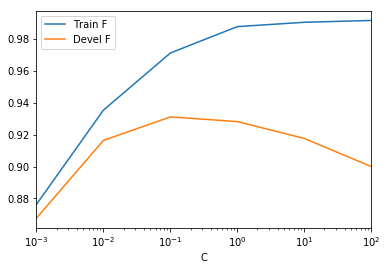

In [29]:
%matplotlib inline

from pandas import DataFrame


DataFrame(results).plot(x='C', y=['Train F', 'Devel F'], logx=True) ;

This is a typical pattern:

* For small values of C, the SVM *underfits*: performance is low even on the training data
* For large values of C, it *overfits*: performance on training data gets close to 100%, but performance on unseen data drops

(The following illustrations are regression instead of classification, but the idea is the same.)

<img src="figs/overfitting.png" width=50%>

<div style="text-align:center; font-size:80%">Overfitting: A better fit for training data (filled circles) does not guarantee generalization to unseen data (empty circles)</div>

<img src="figs/underfitting.png" width=50%>

<div style="text-align:center; font-size:80%">Underfitting: a simpler model isn't necessarily better. (Filled circles represent training data, empty circles unseen data.)</div>

---

## Feature weighting

* We have so far used present/absent (1/0) or simple occurrence counts as feature values
* Features can be assigned any values, and weighting important features highly (and vice versa) can help ML methods learn
    * (Ignoring common *stopwords* such as "a" and "the" can be seen as an extreme example of this)

### TF-IDF weighting

* Popular and effective statistic measuring the importance of word in a set of documents
* Term frequency (TF($w$)): count of word $w$ in current document (cf. counts in bags-of-words)
* Inverse Document Frequency (IDF): 1 / fraction of documents where word occurs

One possible formulation (of many):

$$\textrm{TF-IDF}(w) = \textrm{TF}(w)\cdot\log\left(\frac{\textrm{N}}{\textrm{DF}(w)}\right)$$

* N is the total number of documents in the data
* DF($w$) is the number of documents where word $w$ occurs

Let's try that out:

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer


def vectorize_and_train(train, vectorizer):
    vectorizer.fit(train['text'])
    train_X = vectorizer.transform(train['text'])
    classifier = LinearSVC(C=1, max_iter=10000)
    classifier.fit(train_X, train['class'])
    return classifier


def predict_and_evaluate(classifier, test, vectorizer):
    test_X = vectorizer.transform(test['text'])
    pred_classes = classifier.predict(test_X)
    return f1_score(test['class'], pred_classes)


count_vectorizer = CountVectorizer(tokenizer=basic_tokenizer)
tfidf_vectorizer = TfidfVectorizer(tokenizer=basic_tokenizer)

count_classifier = vectorize_and_train(train_texts, count_vectorizer)
tfidf_classifier = vectorize_and_train(train_texts, tfidf_vectorizer)

print('Count  F-score  : {:.2%}'.format(predict_and_evaluate(count_classifier, devel_texts, count_vectorizer)))
print('TF-IDF F-score  : {:.2%}'.format(predict_and_evaluate(tfidf_classifier, devel_texts, tfidf_vectorizer)))

Count  F-score  : 92.83%
TF-IDF F-score  : 93.56%


Nice! How did the learned weights change?

In [31]:
eli5.show_weights(count_classifier, vec=count_vectorizer, top=25)

Weight?,Feature
+1.659,learn
+1.655,rolex
+1.553,money
+1.441,girls
+1.439,invite
+1.437,rotor
+1.433,404
+1.429,doctor
+1.426,1776
+1.417,impaired


In [32]:
eli5.show_weights(tfidf_classifier, vec=tfidf_vectorizer, top=25)

---

## N-gram features

* Create features from sequences of *N* consecutive words or characters
* Word N-grams, the more common choice, provide (limited) sequence information
* Character N-grams capture (some) word-internal information and can help with e.g. misspelled words

In [33]:
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,5))
bigram_vectorizer =  TfidfVectorizer(tokenizer=basic_tokenizer, ngram_range=(1,2))

char_classifier = vectorize_and_train(train_texts, char_vectorizer)
bigram_classifier = vectorize_and_train(train_texts, bigram_vectorizer)

print('Char n-gram F-score  : {:.2%}'.format(predict_and_evaluate(char_classifier, devel_texts, char_vectorizer)))
print('Bigram F-score  : {:.2%}'.format(predict_and_evaluate(bigram_classifier, devel_texts, bigram_vectorizer)))

Char n-gram F-score  : 93.58%
Bigram F-score  : 94.38%


In [34]:
eli5.show_weights(char_classifier, vec=char_vectorizer, top=50)

Weight?,Feature
+1.786,you
+1.751,a
+1.696,!
+1.693,gent
+1.622,","
+1.616,$
+1.526,med
+1.443,ns !
+1.303,[
+1.265,: ord


In [35]:
eli5.show_weights(bigram_classifier, vec=bigram_vectorizer, top=50)

Weight?,Feature
+3.042,your
+2.214,$
+2.188,you
+2.127,%
+2.112,free
+2.044,stock
+1.835,online
+1.833,new schedule
+1.799,2005
+1.750,2004


---

##  Comparing results (aka. making your numbers look bigger)

(Don't take this too seriously)

Recall the performance of the simple initial Naive Bayes classifier:

In [36]:
pred_classes = nb_classifier.classify_many(devel_data)
nb_accuracy = scores.accuracy(devel_classes, pred_classes)
print('Naive Bayes accuracy: {:.2%}'.format(nb_accuracy))

Naive Bayes accuracy: 93.04%


And our latest, finest SVM:

In [37]:
devel_X = bigram_vectorizer.transform(devel_texts['text'])
pred_classes = bigram_classifier.predict(devel_X)
svm_accuracy = scores.accuracy(devel_classes, pred_classes)
print('SVM accuracy: {:.2%}'.format(svm_accuracy))

SVM accuracy: 94.47%


Was it worth it?

In [38]:
print('Difference: {:.2%} points'.format(svm_accuracy-nb_accuracy))

Difference: 1.42% points


This doesn't look terribly impressive. Let's change perspective:

In [39]:
from IPython.core.display import HTML


nb_error = 1 - nb_accuracy
svm_error = 1 - svm_accuracy
relative_reduction_in_error = (nb_error - svm_error) / nb_error

HTML('<h1>Relative reduction in error: {:.2%}</h1>'.format(relative_reduction_in_error))

Much better.

---

# Improve the model further

There are many ways that we could still try to further improve the model, for example

* Additional hyperparameter optimization
* Feature weighting variants (see [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html))
* Different values of N for N-gram representations
* Combination of character and word features

(Exercise)

---

# Finnish topic classification

On the server in `/course_data/textmine/suomi24/` you can find a Finnish topic classification dataset in the format used here. Train at least one SVM classifier on this data and evaluate its performance.

(Exercise. Note that this does not require an understanding of Finnish.)